Importing Useful Libraries

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xmltodict
from collections import Counter

import torch
from torchvision import datasets
from torchvision import transforms as T
from torch.utils.data import dataset
from PIL import Image

import neptune.new as neptune


In [2]:
CFG = {
    'n_epochs': 10,
    'optimizer': 'adam',
    'lr': 0.01,
    'batch_size': 32,
}

In [3]:
run = neptune.init(
    project="cveatt/mask-detection",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjZDc4N2M0Zi02NDU2LTRkODYtODlmZC1jNTczNzVlMzQ5M2YifQ==",
)

https://app.neptune.ai/cveatt/mask-detection/e/MASK-2
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


Annotation and Images Extraction

In [4]:
images = 'face-mask-detection/images/'
annotations = 'face-mask-detection/annotations/'

In [5]:
img_names = []
xml_names = []
for dirname, _, filenames in os.walk('face-mask-detection'):
    for filename in filenames:
        if os.path.join(dirname, filename)[-3:] != 'xml':
            img_names.append(filename)
        else:
            xml_names.append(filename)

In [6]:
listing=[]
for i in img_names[:]:
    with open(annotations + i[:-4] + '.xml') as fd:
        doc = xmltodict.parse(fd.read())
    temp = doc['annotation']['object']
    if type(temp) == list:
        for i in range(len(temp)):
            listing.append(temp[i]['name'])
    else:
        listing.append(temp['name'])
        

Items = Counter(listing).keys()
values = Counter(listing).values()
print(Items, '\n', values)

dict_keys(['without_mask', 'with_mask', 'mask_weared_incorrect']) 
 dict_values([717, 3232, 123])


Visualisation and Analysis

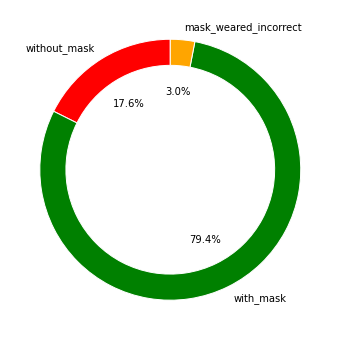

In [7]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.pie(values, wedgeprops = dict(width=0.2, edgecolor='w'), labels=Items, colors=['red', 'green', 'orange'], startangle=90, autopct='%1.1f%%')
plt.show()

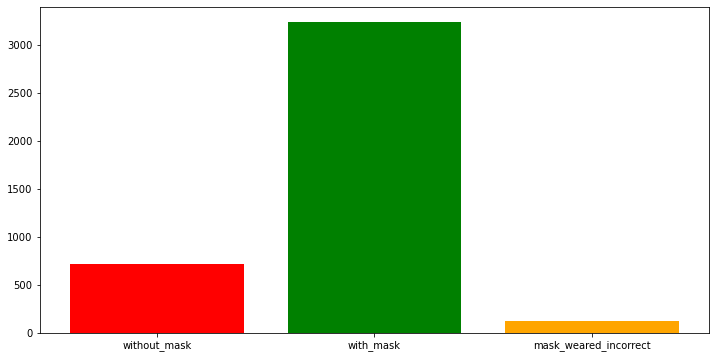

In [8]:
fig, ax = plt.subplots(figsize = (12, 6))
ax = plt.bar(Items, list(values), color=['red', 'green', 'orange'])
plt.show()

In [9]:
print('======================== Data Summary ========================')
print(f'Total Images: {sum(values)}')
print('--------------------------------------------------------------')
print(f'Total Faces with Masks: {list(values)[1]} / {list(values)[1] / sum(values) * 100 :.1f} %')
print(f'Total Faces without Masks: {list(values)[0]} / {list(values)[0] / sum(values) * 100 :.1f} %')
print(f'Totatl Faces with Improper Masks: {list(values)[2]} / {list(values)[2] / sum(values) * 100 :.1f} %')
print('===========================================================')

======================== Data Summary ========================
Total Images: 4072
--------------------------------------------------------------
Total Faces with Masks: 3232 / 79.4 %
Total Faces without Masks: 717 / 17.6 %
Totatl Faces with Improper Masks: 123 / 3.0 %


Images Identification

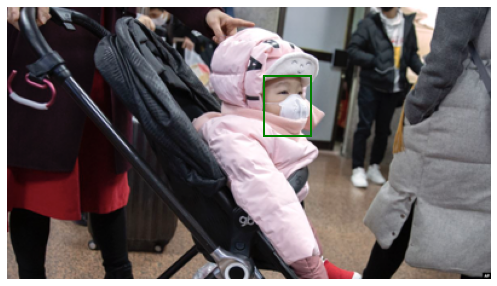

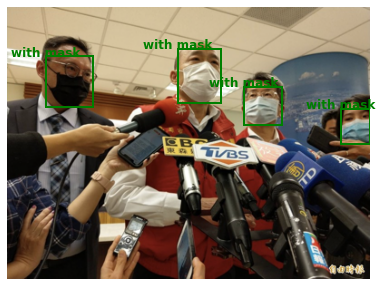

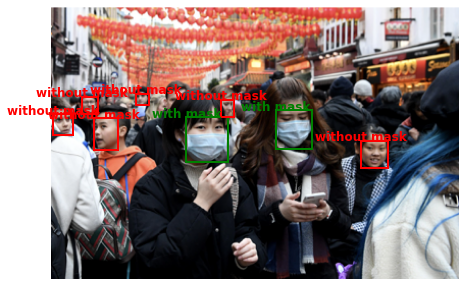

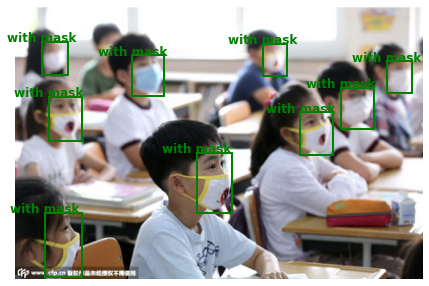

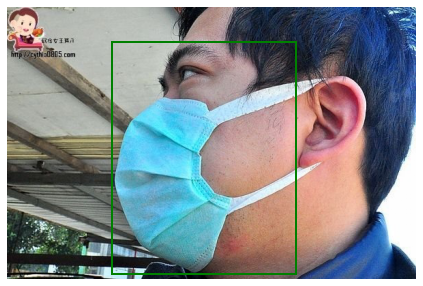

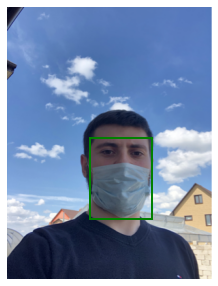

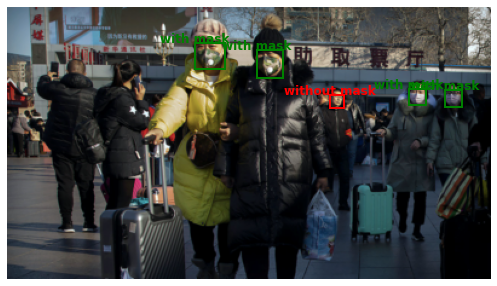

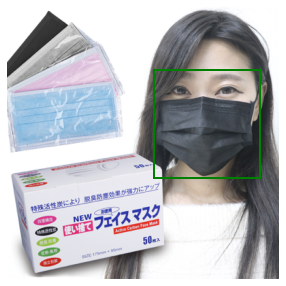

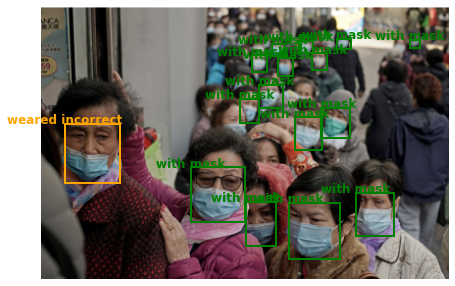

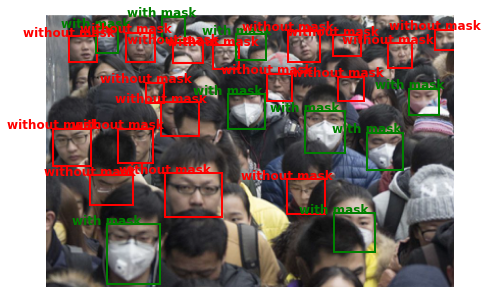

In [10]:
def face_check(img): 
    with open(annotations + img[:-4] + '.xml') as fd:
        doc = xmltodict.parse(fd.read())
    image = plt.imread(os.path.join(images + img))
    fig, ax = plt.subplots(1)
    ax.axis('off')
    fig.set_size_inches(10, 5)
    temp = doc['annotation']['object']
    if type(temp) == list:
        for i in range(len(temp)):
            #with_mask
            if temp[i]['name'] == 'with_mask':
                x, y, w, h = list(map(int, temp[i]['bndbox'].values()))
                mpatch = mpatches.Rectangle((x, y), w - x, h - y, edgecolor='green', facecolor='none', lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate('with mask', (rx, ry), color='green', weight='bold', fontsize=12, ha='center', va='baseline')
            #without_mask
            if temp[i]['name'] == 'without_mask':
                x, y, w, h = list(map(int, temp[i]['bndbox'].values()))     
                mpatch = mpatches.Rectangle((x, y), w - x, h - y, edgecolor='red', facecolor='none', lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate('without mask', (rx, ry), color='red', weight='bold', fontsize=12, ha='center', va='baseline')
            #mask_weared_incorrect
            if temp[i]['name'] == 'mask_weared_incorrect':
                x, y, w, h = list(map(int, temp[i]['bndbox'].values()))
                mpatch = mpatches.Rectangle((x, y), w - x, h - y, edgecolor='orange', facecolor='none', lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate('weared incorrect', (rx, ry), color='orange', weight='bold', fontsize=12, ha='center', va='baseline')
    else:
        x, y, w, h = list(map(int, temp['bndbox'].values()))
        edgecolor = {'with_mask': 'green', 'without_mask': 'red', 'mask_weared_incorrect': 'orange'}
        mpatch = mpatches.Rectangle((x, y), w - x, h - y, lw=2, edgecolor = edgecolor[temp['name']], facecolor='none',)
    ax.imshow(image)
    ax.add_patch(mpatch)

func_img = img_names.copy()
for i in range(5, 15):
    face_check(func_img[i])


Image Processing

In [11]:
options = {'with_mask': 0, 'without_mask': 1, 'mask_weared_incorrect': 2}

In [12]:
def create_dataset(image_list): 
    image_tensor=[]
    label_tensor=[]
    for i,j in enumerate(image_list):
        with open(annotations + j[:-4] + '.xml') as fd:
            doc = xmltodict.parse(fd.read())
        if type(doc['annotation']['object']) != list:
            temp = doc['annotation']['object']
            x, y, w, h = list(map(int, temp['bndbox'].values()))
            label = options[temp['name']]
            image = T.functional.crop(Image.open(images + j).convert('RGB'), y, x, h - y, w - x)
            image_tensor.append(my_transform(image))
            label_tensor.append(torch.tensor(label))
        else:
            temp = doc['annotation']['object']
            for k in range(len(temp)):
                x, y, w, h = list(map(int, temp[k]['bndbox'].values()))
                label = options[temp[k]['name']]
                image = T.functional.crop(Image.open(images + j).convert('RGB'), y, x, h - y, w - x)
                image_tensor.append(my_transform(image))
                label_tensor.append(torch.tensor(label))
                
    full_dataset = [[k,l] for k, l in zip(image_tensor, label_tensor)]
    return tuple(full_dataset)


my_transform = T.Compose([T.Resize((226,226)), T.ToTensor()])

mydataset = create_dataset(img_names)

In [13]:
mydataset[0]

[tensor([[[0.4941, 0.4941, 0.4941,  ..., 0.6157, 0.6157, 0.6157],
          [0.4941, 0.4941, 0.4941,  ..., 0.6157, 0.6157, 0.6157],
          [0.4941, 0.4941, 0.4941,  ..., 0.6157, 0.6157, 0.6157],
          ...,
          [0.1843, 0.1843, 0.1843,  ..., 0.3216, 0.3216, 0.3216],
          [0.1843, 0.1843, 0.1843,  ..., 0.3216, 0.3216, 0.3216],
          [0.1843, 0.1843, 0.1843,  ..., 0.3216, 0.3216, 0.3216]],
 
         [[0.4431, 0.4431, 0.4431,  ..., 0.5216, 0.5216, 0.5216],
          [0.4431, 0.4431, 0.4431,  ..., 0.5216, 0.5216, 0.5216],
          [0.4431, 0.4431, 0.4431,  ..., 0.5216, 0.5216, 0.5216],
          ...,
          [0.1216, 0.1216, 0.1216,  ..., 0.1647, 0.1647, 0.1647],
          [0.1216, 0.1216, 0.1216,  ..., 0.1647, 0.1647, 0.1647],
          [0.1216, 0.1216, 0.1216,  ..., 0.1647, 0.1647, 0.1647]],
 
         [[0.4784, 0.4784, 0.4784,  ..., 0.5216, 0.5216, 0.5216],
          [0.4784, 0.4784, 0.4784,  ..., 0.5216, 0.5216, 0.5216],
          [0.4784, 0.4784, 0.4784,  ...,

In [14]:
train_size = int(0.8 * len(mydataset))
test_size = len(mydataset) - train_size
print('Lenght of training set:', train_size, '\nLenght of test set:', test_size)

Lenght of training set: 3257 
Lenght of test set: 815


Dataset and Dataloader

In [15]:
train_dataset, test_dataset = torch.utils.data.random_split(mydataset, [train_size, test_size])

In [16]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = CFG['batch_size'],
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = CFG['batch_size'],
    shuffle=False,
)

In [17]:
train_features, train_labels = next(iter(train_loader))
print(f' Features batch shape: {train_features.size()}')
print(f' Labels batch shape: {train_labels.size()}')

 Features batch shape: torch.Size([32, 3, 226, 226])
 Labels batch shape: torch.Size([32])


Model